In [1]:
## import torch
import tqdm
import numpy as np
import cv2
import imageio
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.io import imsave
from skimage.transform import warp
from skimage.measure import compare_psnr
from skimage.metrics import structural_similarity as ssim
from utils.common_utils import *
import warnings
from torchsummary import summary
from skimage import segmentation
from networks.conv_layers import *
from networks.skip import skip
from networks.unet import UNet

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

warnings.filterwarnings("ignore")

imsize = -1 

batch_size = 10

pname = 'cactus_syn'
start_f = 1
fname = 'data/Ablation_data/{}/img'.format(pname)
fgt = 'data/Ablation_data/{}/GT/{}_GT.png'.format(pname,pname)
# fgt = 'test_data/Our/Synthetic/Set1/GT/{}.jpg'.format(pname)
scale_factor = 1

pname = 'chimney'
start_f = 4 # 170020 170035 170050
fname = 'data/stanley/{}_sel/'.format(pname)
fgt = 'data/stanley/{}_gt.png'.format(pname)
# fgt = 'test_data/Our/Synthetic/Set1/GT/{}.jpg'.format(pname)
scale_factor = 0.7

pname = 'building'
start_f = 4 # 170020 170035 170050
fname = 'data/stanley/{}_sel2/'.format(pname)
fgt = 'data/stanley/{}_gt.png'.format(pname)
# fgt = 'test_data/Our/Synthetic/Set1/GT/{}.jpg'.format(pname)
scale_factor = 0.7

fresult = 'result_iccv_rebuttal/{}'.format(pname)


if not os.path.exists(fresult):
    os.makedirs(fresult)

cuda


# Utility Functions

In [2]:
def backwarp(tenInput, tenFlow):
    backwarp_tenGrid = {}
    if str(tenFlow.size()) not in backwarp_tenGrid:
        tenHorizontal = torch.linspace(-1.0, 1.0, tenFlow.shape[3]).view(1, 1, 1, tenFlow.shape[3]).expand(tenFlow.shape[0], -1, tenFlow.shape[2], -1)
        tenVertical = torch.linspace(-1.0, 1.0, tenFlow.shape[2]).view(1, 1, tenFlow.shape[2], 1).expand(tenFlow.shape[0], -1, -1, tenFlow.shape[3])

        backwarp_tenGrid[str(tenFlow.size())] = torch.cat([ tenHorizontal, tenVertical ], 1).cuda()
    # end

    tenFlow = torch.cat([ tenFlow[:, 0:1, :, :] / ((tenInput.shape[3] - 1.0) / 2.0), tenFlow[:, 1:2, :, :] / ((tenInput.shape[2] - 1.0) / 2.0) ], 1)

    return torch.nn.functional.grid_sample(input=tenInput, grid=(backwarp_tenGrid[str(tenFlow.size())] + tenFlow).permute(0, 2, 3, 1), mode='bilinear', padding_mode='zeros')

def backwarp_grid(tenInput, tenFlow_xy):

    return torch.nn.functional.grid_sample(input=tenInput, grid = tenFlow_xy.permute(0, 2, 3, 1), mode='bilinear', padding_mode='zeros')

def im_resize(im, scale_factor):
    width = int(im.size[1] * scale_factor)
    height = int(im.size[0] * scale_factor)
    newsize = (height,width) 
#     im1 = im.resize(newsize) 
    return im.resize(newsize) 

def visualize_rgb(warp_np):
#     warp_np = warp_np.transpose(1,2,0)
    nr = warp_np.shape[0]
    nc = warp_np.shape[1]    
    warp_np = (warp_np - np.amin(warp_np))/(np.amax(warp_np) - np.amin(warp_np))
    one_pad = np.ones((nr, nc, 1))
    out_warp_np = np.concatenate((warp_np,one_pad),axis = -1)
    return out_warp_np

def visualize_rgb_norm(warp_np):
#     warp_np = warp_np.transpose(1,2,0)
    nr = warp_np.shape[0]
    nc = warp_np.shape[1]    
#     warp_np = (warp_np - np.amin(warp_np))/(np.amax(warp_np) - np.amin(warp_np))
    one_pad = np.ones((nr, nc, 1))
    out_warp_np = np.concatenate((warp_np,one_pad),axis = -1)
    return out_warp_np

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.

    Args:
        filename (string): path to a file

    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)

# Load Turbulence Images 

(3, 242, 241)
(10, 3, 168, 168)
(3, 168, 168)
(3, 168, 168)


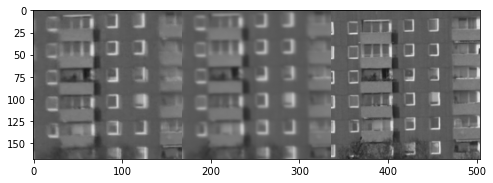

In [3]:
# Load reference GT pattern. If none, load a single turbulence image
img_gt_rgb,img_gt_np = get_image(fgt, imsize)
img_gt_np  = img_gt_np[:3,:,:]
dim_gt = img_gt_np.shape[0]
if dim_gt ==1:
    img_gt_np = np.concatenate((img_gt_np, img_gt_np,img_gt_np), 0)    
print(img_gt_np.shape)
 

images = []
i = 0
# # Load turbulence image batch

extensions = ['.jpg', '.JPG', '.png', '.ppm', '.bmp', '.pgm', '.tif']
# Load image by sorted name
for target in sorted(os.listdir(fname)):
    d = os.path.join(fname, target)
    if has_file_allowed_extension(d, extensions) and i < batch_size:
#         print(d)
        i = i+1
        rgb, imgs = get_image(d, imsize)
        imgs = pil_to_np(im_resize(rgb,scale_factor))
        dim = imgs.shape[0]
        if dim ==1:
            imgs = np.concatenate((imgs, imgs,imgs), 0)        
        images.append(imgs)

# for b in range(batch_size):   
# #     d = '{}/imgage_{:03d}.png'.format(fname,b+start_f)
#     d = '{}/hotair_{:d}.png'.format(fname,b+start_f)
# #     d = '{}/thumb{:04d}.png'.format(fname,b+start_f)
#     i = i+1
#     rgb, imgs = get_image(d, imsize)
#     imgs = pil_to_np(im_resize(rgb,scale_factor))
#     images.append(imgs)
             
               
images_warp_np = np.array(images)
print(images_warp_np.shape)
images_mean_np = np.mean(images_warp_np, axis = 0)
print(images_mean_np.shape)
dim, nr, nc = images_mean_np.shape
# scale_factor_gt = nr/img_gt_np.shape[1]

# imsave('{}/{}_mean_{}.png'.format(fresult,pname,batch_size), images_mean_np.transpose(1,2,0))


# img_gt_np = images_mean_np

if dim>1:
    img_gt_np = cv2.resize(img_gt_np.transpose(1,2,0), dsize=(nc, nr), interpolation=cv2.INTER_AREA).transpose(2,0,1)
    print(img_gt_np.shape)
else:
    img_gt_np = cv2.resize(img_gt_np.transpose(1,2,0), dsize=(nc, nr), interpolation=cv2.INTER_AREA)
    print(img_gt_np.shape)

# img_gt_np = img_gt_np.transpose(2,0,1)
out_imshow = np.concatenate([images_warp_np[0].transpose(1,2,0),images_mean_np.transpose(1,2,0),img_gt_np.transpose(1,2,0)], axis = 1)
plt.figure(figsize=(8,5))
plt.imshow(out_imshow)
plt.show()

# Setup Fourier Feature Transform function

In [4]:
class GaussianFourierFeatureTransform_B(torch.nn.Module):
    """
    An implementation of Gaussian Fourier feature mapping.

    "Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains":
       https://arxiv.org/abs/2006.10739
       https://people.eecs.berkeley.edu/~bmild/fourfeat/index.html

    Given an input of size [batches, num_input_channels, width, height],
     returns a tensor of size [batches, mapping_size*2, width, height].
    """

    def __init__(self, num_input_channels, B, mapping_size=256, scale=10):
        super().__init__()

        self._num_input_channels = num_input_channels
        self._mapping_size = mapping_size
        self._B = B*scale
#         self._B = torch.load('{}/{}_tensor_B.pt'.format(fresult,pname))

    def forward(self, x):
        assert x.dim() == 4, 'Expected 4D input (got {}D input)'.format(x.dim())

        batches, channels, width, height = x.shape

        assert channels == self._num_input_channels,\
            "Expected input to have {} channels (got {} channels)".format(self._num_input_channels, channels)

        # Make shape compatible for matmul with _B.
        # From [B, C, W, H] to [(B*W*H), C].
        x = x.permute(0, 2, 3, 1).reshape(batches * width * height, channels)

        x = x @ self._B.to(x.device)

        # From [(B*W*H), C] to [B, W, H, C]
        x = x.view(batches, width, height, self._mapping_size)
        # From [B, W, H, C] to [B, C, W, H]
        x = x.permute(0, 3, 1, 2)

        x = 2 * np.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=1)

In [5]:
# Generate straight grid batch for shape image
xy_grid_batch = []
coords_x = np.linspace(-1, 1, nc)
coords_y = np.linspace(-1, 1, nr)
xy_grid = np.stack(np.meshgrid(coords_x, coords_y), -1)

xy_grid_var = np_to_torch(xy_grid.transpose(2,0,1)).type(dtype).cuda()
xy_grid_batch_var = xy_grid_var.repeat(batch_size, 1, 1, 1)
print(xy_grid_batch_var.shape)

torch.Size([10, 2, 168, 168])


# Setup Image Generator

In [6]:
model_grid = conv_layers(256,3)
model_grid = model_grid.type(dtype)
# print(model_grid)
summary(model_grid,(256, nr, nc))

# load saved B or generate a new B
# B_var = torch.load('result/Pattern4/Pattern4_tensor_B.pt')
torch.manual_seed(0)

B_var = torch.randn(2,128)
print(B_var.shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 256, 168, 168]       65,792
├─ReLU: 1-2                              [-1, 256, 168, 168]       --
├─BatchNorm2d: 1-3                       [-1, 256, 168, 168]       512
├─Conv2d: 1-4                            [-1, 256, 168, 168]       65,792
├─ReLU: 1-5                              [-1, 256, 168, 168]       --
├─Conv2d: 1-6                            [-1, 256, 168, 168]       65,792
├─ReLU: 1-7                              [-1, 256, 168, 168]       --
├─Conv2d: 1-8                            [-1, 3, 168, 168]         771
├─Sigmoid: 1-9                           [-1, 3, 168, 168]         --
Total params: 198,659
Trainable params: 198,659
Non-trainable params: 0
Total mult-adds (G): 5.57
Input size (MB): 27.56
Forward/backward pass size (MB): 221.15
Params size (MB): 0.76
Estimated Total Size (MB): 249.47
torch.Size([2, 128])


# Setup Grid deformer network 

In [7]:
# Use the skip net as grid deformor

input_depth_warp = 8
# INPUT = 'noise'
pad = 'reflection'

# -------------------------------------Use 10 grid-deform networks ---------------------------
model_vec = []
# for i in range(batch_size):
#     model_vec.append(conv_layers(256,2, need_sigmoid = False, need_tanh = True).to(device))

# sum1 = summary(model_vec[0],(256, nr, nc))
for i in range(batch_size):
    model_vec.append(conv_layers(2,2, need_sigmoid = False, need_tanh = True).to(device))

sum1 = summary(model_vec[0],(2, nr, nc))

# -------------------------------------Use 1 grid-deform networks ---------------------------
# model_vec = conv_layers(2,2, need_sigmoid = False, need_tanh = True)

# model_vec = skip(2, 2,
#             num_channels_down = [128, 128, 128, 128, 128],   
#             num_channels_up   = [128, 128, 128, 128, 128],
#             num_channels_skip = [16, 16, 16, 16, 16],
#             upsample_mode='bilinear',
#             need_sigmoid=False, need_tanh=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

# model_vec = model_vec.type(dtype)
# # sum1 = summary(model_vec,(256, nr, nc))
# sum1 = summary(model_vec,(2, nr, nc))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 256, 168, 168]       768
├─ReLU: 1-2                              [-1, 256, 168, 168]       --
├─BatchNorm2d: 1-3                       [-1, 256, 168, 168]       512
├─Conv2d: 1-4                            [-1, 256, 168, 168]       65,792
├─ReLU: 1-5                              [-1, 256, 168, 168]       --
├─Conv2d: 1-6                            [-1, 256, 168, 168]       65,792
├─ReLU: 1-7                              [-1, 256, 168, 168]       --
├─Conv2d: 1-8                            [-1, 2, 168, 168]         514
├─Tanh: 1-9                              [-1, 2, 168, 168]         --
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
Total mult-adds (G): 3.73
Input size (MB): 0.22
Forward/backward pass size (MB): 220.93
Params size (MB): 0.51
Estimated Total Size (MB): 221.65


# Network Initializaiton

In [8]:
# The input turbulent images

# The frequence bandwith for the turbulence field
# For air turbulence
FB_img = 8
FB_turb = 0.1

# For fluid
# FB_img = 10
# FB_turb = 0.02


vec_scale = 1.1

reg_noise_std = 1./30. # set to 1./30 works fine

img_gt_batch_var = torch.from_numpy(images_warp_np).type(dtype).cuda()
straight_grid_input = GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(xy_grid_batch_var)
# -------------------------------SETUP Grid deformer---------------------------------------------------
# straight_grid_input_gd = GaussianFourierFeatureTransform_B(2, B_var, 128, FB_turb)(xy_grid_batch_var)
grid_input_single_gd = xy_grid_var.detach().clone()
grid_input_gd = xy_grid_batch_var.detach().clone()
# -------------------------------------------------------------------------------------------------------
grid_input = straight_grid_input.detach().clone()


In [9]:
model_params_list = [{'params':model_vec[i].parameters()} for i in range(batch_size)]

model_params_list.append({'params':model_grid.parameters()})

# print(model_params_list)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch 0, loss = 0.621


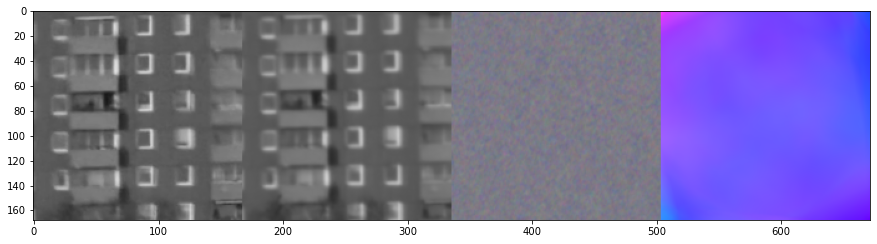

Epoch 100, loss = 0.054


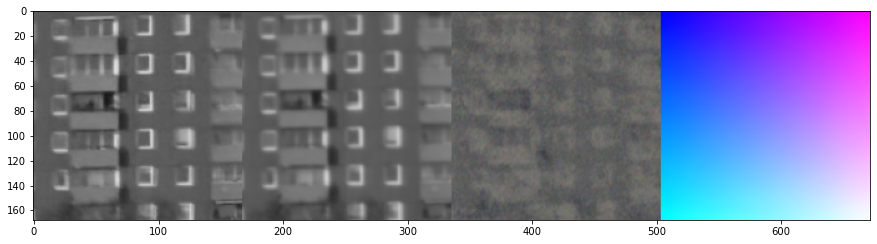

Epoch 200, loss = 0.028


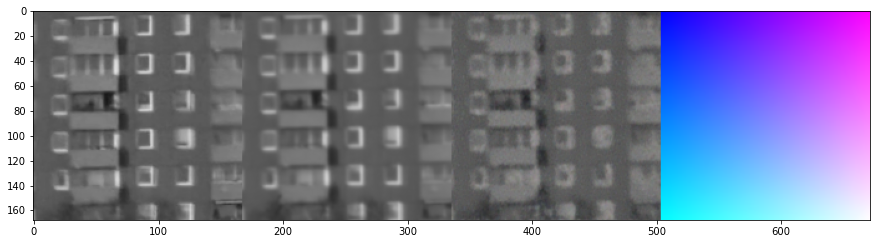

Epoch 300, loss = 0.020


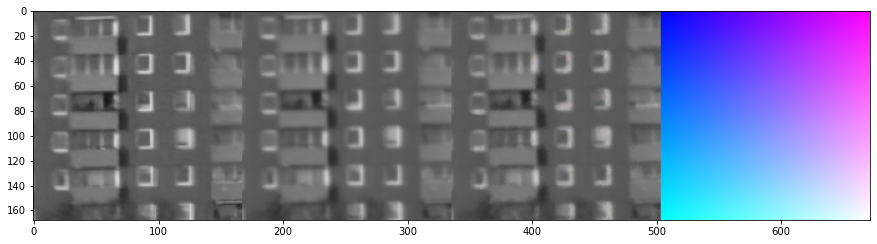

Epoch 400, loss = 0.020


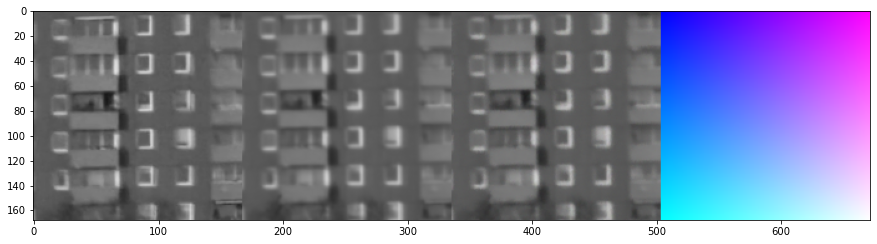

Epoch 500, loss = 0.019


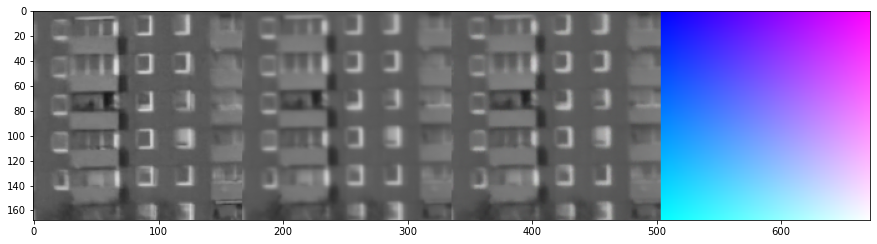

Epoch 600, loss = 0.019


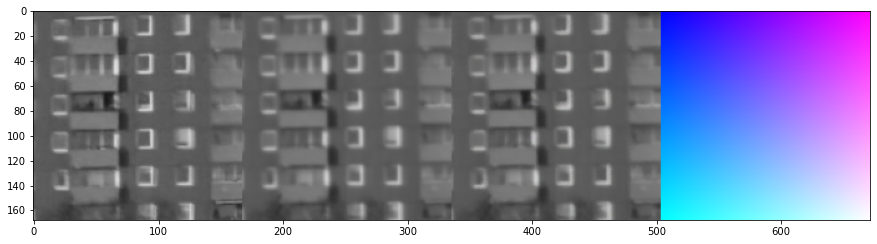

Epoch 700, loss = 0.019


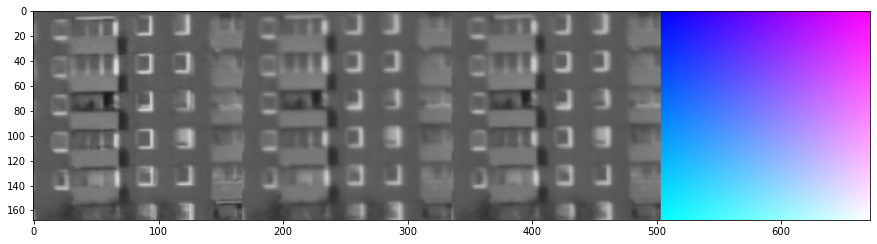

Epoch 800, loss = 0.019


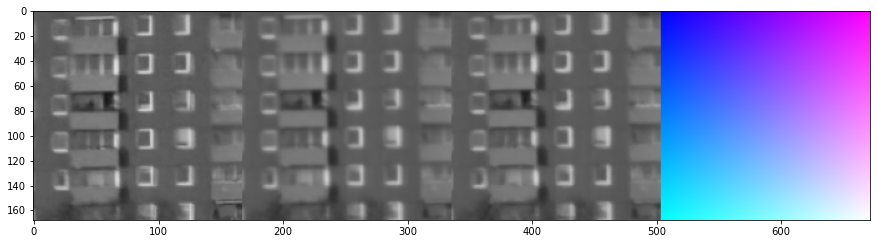

Epoch 900, loss = 0.018


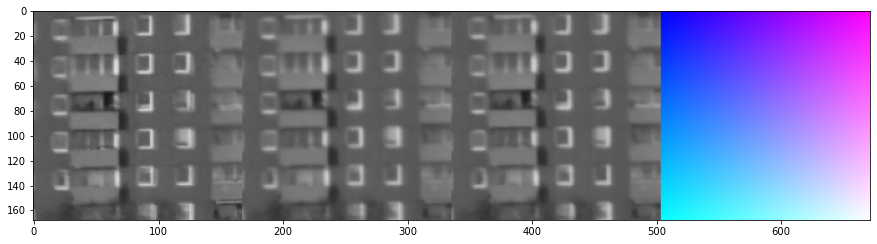

In [10]:
optimizer = torch.optim.Adam(model_params_list, lr=1e-4)

num_iter_i = 1000

# imsave('{}/{}_turb_img_frame_{}.png'.format(fresult,pname,0), images_warp_np[0].transpose(1,2,0))
imsave('{}/{}_avg_img_{}.png'.format(fresult,pname,batch_size), images_mean_np.transpose(1,2,0))
for epoch in tqdm(range(num_iter_i)): 
    
    optimizer.zero_grad()
# -------------------------------SETUP Grid deformer---------------------------------------------------    
    refined_xy = []
    for b in range(batch_size):
#         vec_input = grid_input_single
        vec_input = grid_input_single_gd
        refined_xy.append(model_vec[b](vec_input))
    refined_xy = vec_scale*torch.cat(refined_xy)
# -------------------------------------------------------------------------------------------------------    
#     refined_xy = model_vec(grid_input_gd)
#     refined_xy = vec_scale*refined_xy
# -------------------------------------------------------------------------------------------------------
                
    generated =  model_grid(grid_input)  

    loss = torch.nn.functional.l1_loss(img_gt_batch_var, generated)
    loss += torch.nn.functional.l1_loss(xy_grid_batch_var, refined_xy)    

    loss.backward()
    optimizer.step()   

    if epoch % 100 == 0:
        print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
        out_img = generated[0].detach().cpu().numpy().transpose(1,2,0)
        pred_xy = refined_xy[0].detach().cpu().numpy().transpose(1,2,0)
        out_imshow = np.concatenate([images_warp_np[0].transpose(1,2,0),images_mean_np.transpose(1,2,0),out_img,visualize_rgb(pred_xy)], axis = 1)
        plt.figure(figsize=(15,5))       
        plt.imshow(np.clip(out_imshow,0,1))
        plt.show()                


In [11]:
imsave('{}/{}_ini_{}_{}.png'.format(fresult,pname,FB_img,batch_size), out_img)  

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [12]:
torch.save(model_grid, '{}/{}_gridnet_initalweights_scale_{}_noKG_{}_10warp_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,FB_turb,start_f))
torch.save(model_vec, '{}/{}_vecnet_initalweights_scale_{}_noKG_{}_10warp_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,FB_turb,start_f))
# model_grid = torch.load('{}/{}_gridnet_initalweights_scale_{}_noKG_{}_10warp_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,FB_turb,start_f)).type(dtype).cuda()
# model_vec = torch.load('{}/{}_vecnet_initalweights_scale_{}_noKG_{}_10warp_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,FB_turb,start_f))

In [13]:
img_gt_np = img_gt_np.clip(0,1)

Epoch 0, loss = 0.037, psnr_sharp = 19.313, psnr_turb = 28.363


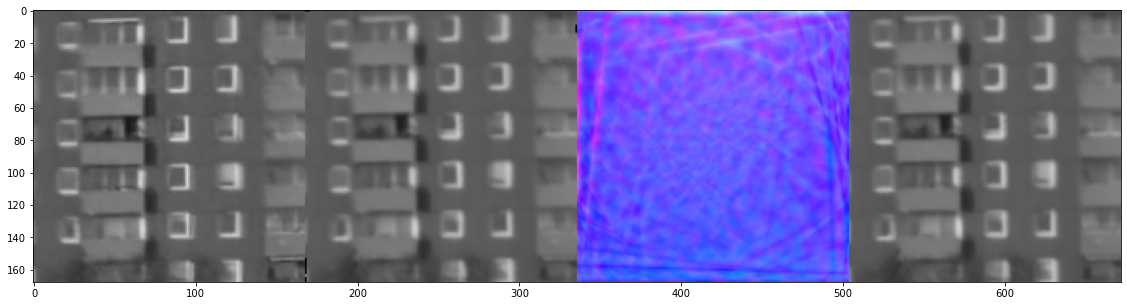

Epoch 100, loss = 0.020, psnr_sharp = 19.183, psnr_turb = 35.226


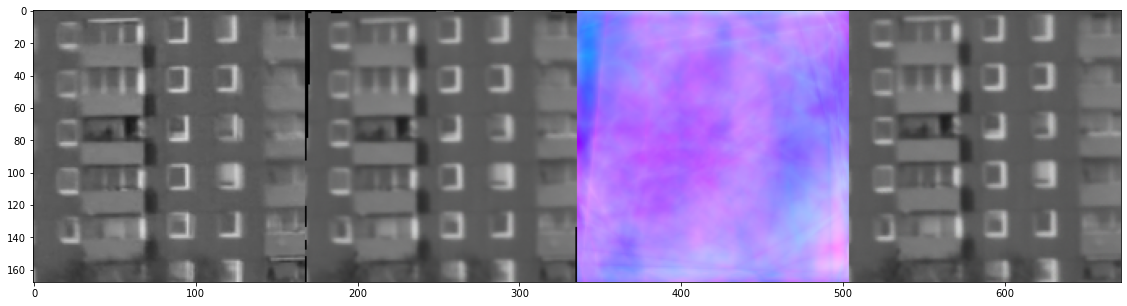

Epoch 200, loss = 0.018, psnr_sharp = 19.163, psnr_turb = 35.604


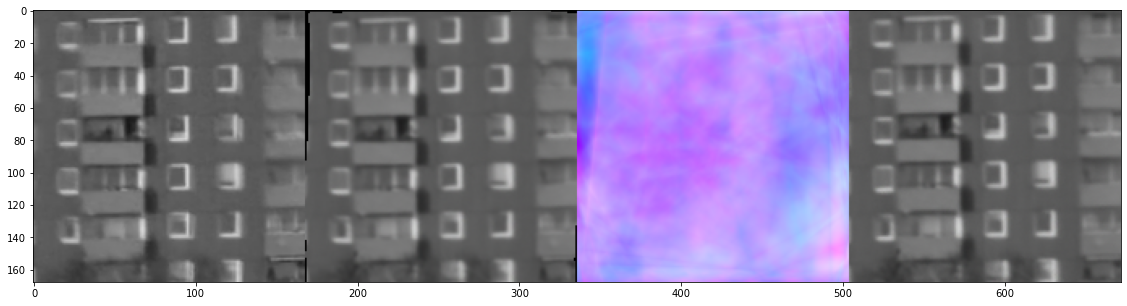

Epoch 300, loss = 0.017, psnr_sharp = 19.150, psnr_turb = 35.866


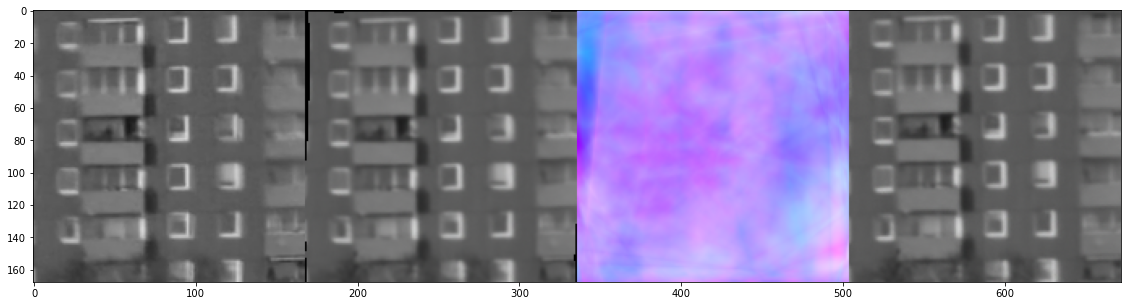

Epoch 400, loss = 0.017, psnr_sharp = 19.141, psnr_turb = 36.019


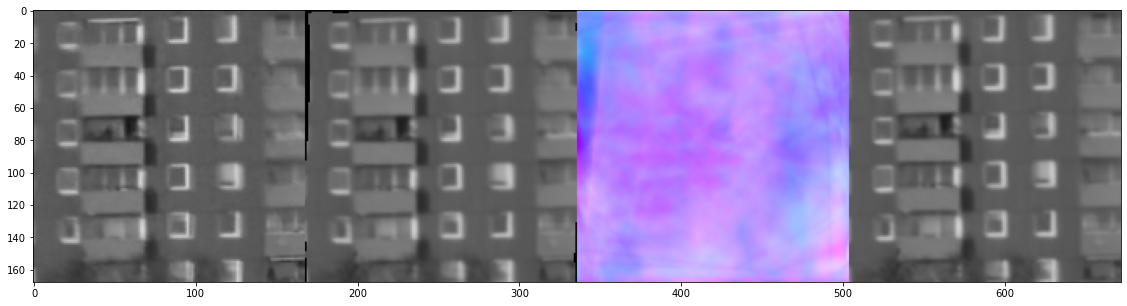

Epoch 500, loss = 0.017, psnr_sharp = 19.134, psnr_turb = 35.980


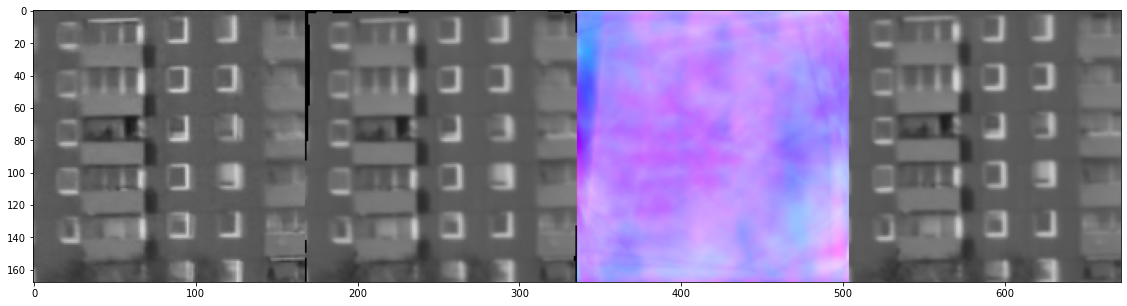

Epoch 600, loss = 0.017, psnr_sharp = 19.129, psnr_turb = 36.083


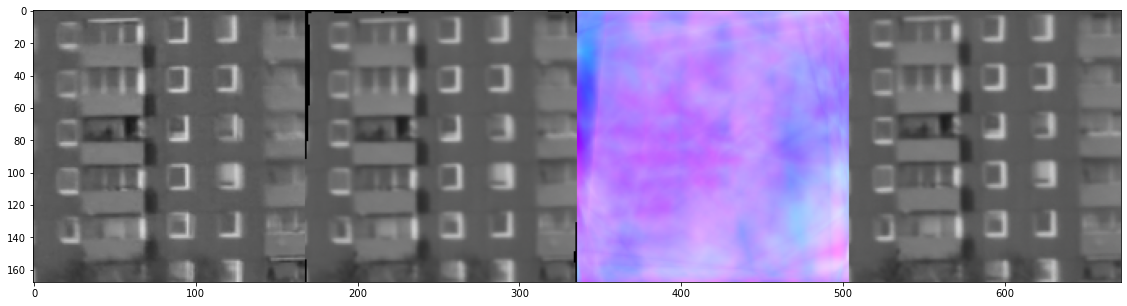

Epoch 700, loss = 0.016, psnr_sharp = 19.125, psnr_turb = 36.158


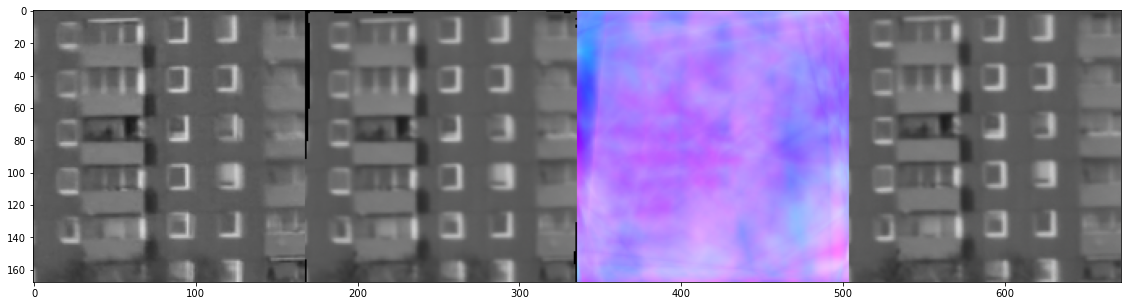

Epoch 800, loss = 0.016, psnr_sharp = 19.120, psnr_turb = 36.219


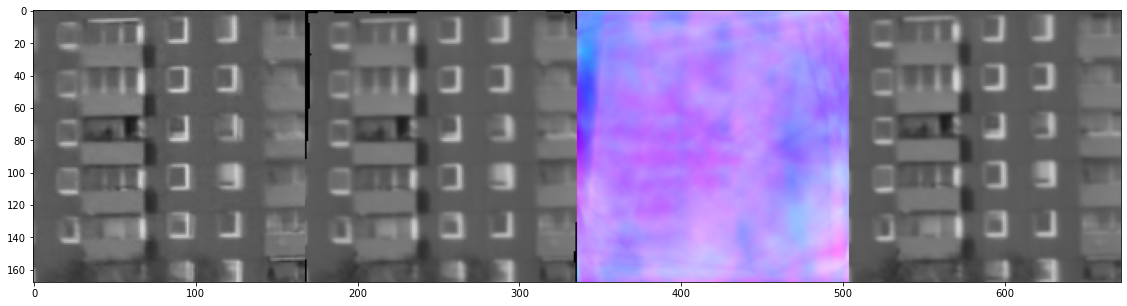

Epoch 900, loss = 0.016, psnr_sharp = 19.116, psnr_turb = 36.203


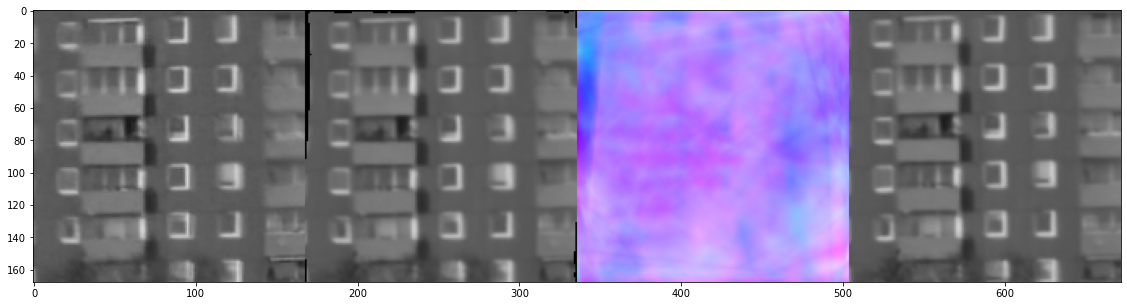

In [14]:
num_iter = 1000
reg_noise_std = 1./30

# the reference frame in the plot
i = 0

loss_arr = torch.zeros(num_iter)
psnr_arr_sharp = torch.zeros(num_iter)
psnr_arr_turb = torch.zeros(num_iter)
ssim_arr_sharp = torch.zeros(num_iter)
ssim_arr_turb = torch.zeros(num_iter)
# seed = torch.seed()

optimizer = torch.optim.Adam(model_params_list, lr=1e-4)

for epoch in tqdm(range(num_iter)):
      
    optimizer.zero_grad()   
    
# -------------------------------SETUP Grid deformer---------------------------------------------------
    refined_xy = []
    for b in range(batch_size):
#         vec_input = grid_input_single 
        vec_input = grid_input_single_gd 
        refined_xy.append(model_vec[b](vec_input))
    
    refined_xy = vec_scale*torch.cat(refined_xy)
# -------------------------------------------------------------------------------------------------------
#     refined_xy = model_vec(grid_input_gd)
#     refined_xy = vec_scale*refined_xy
# -------------------------------------------------------------------------------------------------------
    refined_warp = refined_xy - xy_grid_batch_var
    refined_uv = torch.cat(((nc - 1.0)*refined_warp[:, 0:1, :, :]/2 , (nr - 1.0)*refined_warp[:, 1:2, :, :]/2), 1)
    
    # Get mask for the warp field
    mask_u1 = (refined_xy[:,0:1,:,:] > -1).float() * 1
    mask_u2 = (refined_xy[:,0:1,:,:] < 1).float() * 1 
    mask_v1 = (refined_xy[:,1:2,:,:] > -1).float() * 1
    mask_v2 = (refined_xy[:,1:2,:,:] < 1).float() * 1  
    mask = mask_u1*mask_u2*mask_v1*mask_v2
    
    # predict sharp image using straight grid
    sharp_imgs_predict = model_grid(grid_input)
    
    # predict turbulent image using forward mapping
    refined_turb_imgs = backwarp_grid(sharp_imgs_predict,refined_xy)
    
    # predict turbulent images using sampling grid
    generated_turb_imgs = model_grid(GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(refined_xy))

    # loss function
    loss = torch.nn.functional.l1_loss(generated_turb_imgs*mask,img_gt_batch_var*mask) 
    loss += torch.nn.functional.l1_loss(refined_turb_imgs*mask,img_gt_batch_var*mask)  
    loss += torch.nn.functional.l1_loss(generated_turb_imgs*mask,refined_turb_imgs*mask)
    
#     loss += torch.nn.functional.l1_loss(img_gt_batch_var*mask, sharp_imgs_predict*mask)
#     loss += torch.nn.functional.l1_loss(xy_grid_batch_var, refined_xy)    
    
    loss_arr[epoch] = loss
    psnr_arr_sharp[epoch] = compare_psnr(img_gt_np, sharp_imgs_predict[i].detach().cpu().numpy()) 
    psnr_arr_turb[epoch]   = compare_psnr(images_warp_np[i], generated_turb_imgs[i].detach().cpu().numpy()) 
    ssim_arr_sharp[epoch] = ssim(img_gt_np.transpose(1,2,0), sharp_imgs_predict[i].detach().cpu().numpy().transpose(1,2,0),multichannel=True) 
    ssim_arr_turb[epoch]   = ssim(images_warp_np[i].transpose(1,2,0), generated_turb_imgs[i].detach().cpu().numpy().transpose(1,2,0),multichannel=True)     

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch %d, loss = %.03f, psnr_sharp = %.03f, psnr_turb = %.03f' % (epoch, float(loss), float(psnr_arr_sharp[epoch]), float(psnr_arr_turb[epoch])))
        
        out_img = refined_turb_imgs[i]*mask[i]
        out_img = out_img.detach().cpu().numpy().transpose(1,2,0)
        sharp_img = sharp_imgs_predict[i].detach().cpu().numpy().transpose(1,2,0)
        warp_img= refined_uv[i].detach().cpu().numpy().transpose(1,2,0)
        out_target = images_warp_np[i].transpose(1,2,0)

        out_imshow = np.concatenate([out_target,out_img,visualize_rgb(warp_img),sharp_img], axis = 1)
        plt.figure(figsize=(20,5))       
        plt.imshow(np.clip(out_imshow,0,1))
        plt.show()

0.015900734812021255


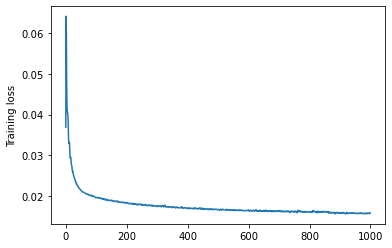

In [15]:
print(float(loss))
loss_arr_np = loss_arr.detach().cpu().numpy()
plt.plot(loss_arr_np[:])
plt.ylabel('Training loss')
plt.show()


In [16]:
torch.save(model_vec, '{}/{}_vectornet_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
torch.save(model_grid, '{}/{}_gridnet_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
torch.save(loss_arr, '{}/{}_loss_final_wIni_10warpnet_noKG_{}_{}pth'.format(fresult,pname,FB_img,batch_size))
torch.save(psnr_arr_sharp, '{}/{}_psnr_sharp_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
torch.save(psnr_arr_turb, '{}/{}_psnr_turb_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
torch.save(ssim_arr_sharp, '{}/{}_ssim_sharp_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
torch.save(ssim_arr_turb, '{}/{}_ssim_turb_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))

# Test

PSNR: 19.114474694957476, SSIM: 0.5917833821467844


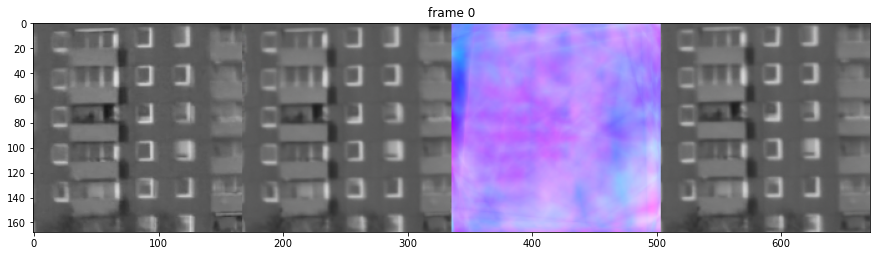

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


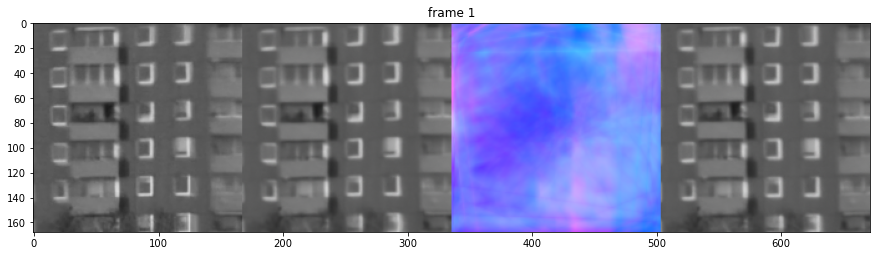

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


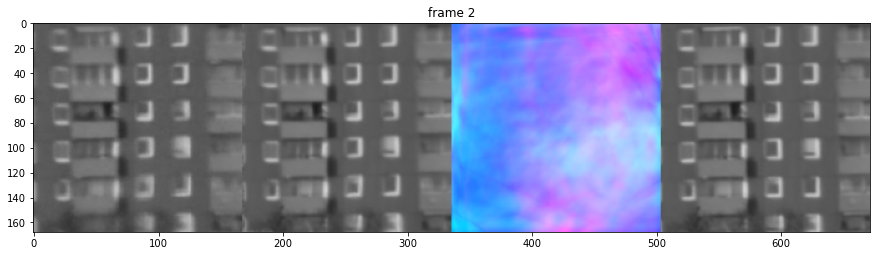

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


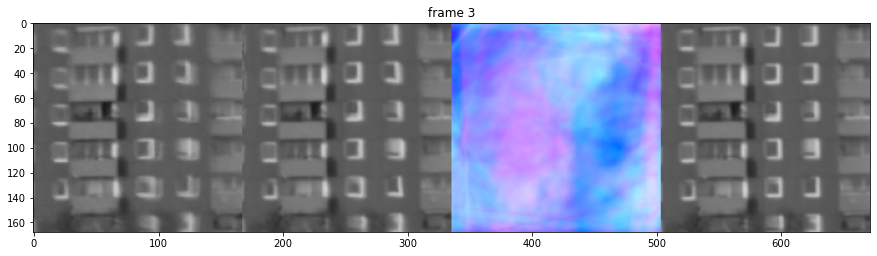

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


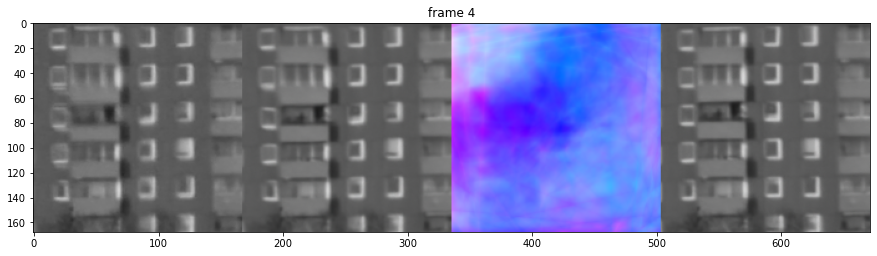

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


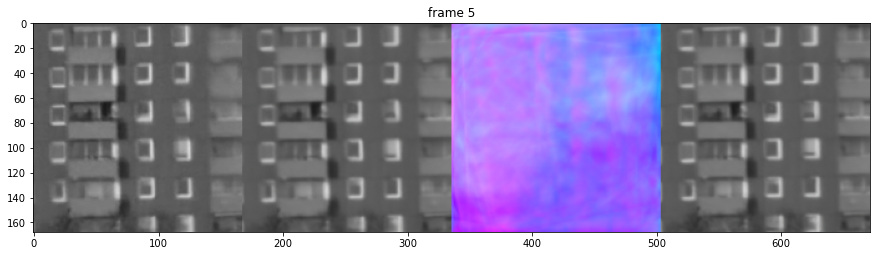

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


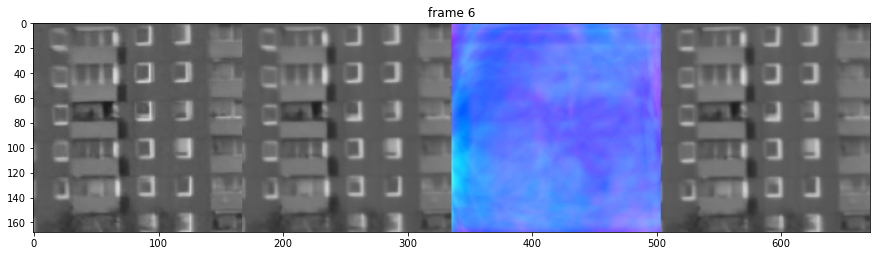

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


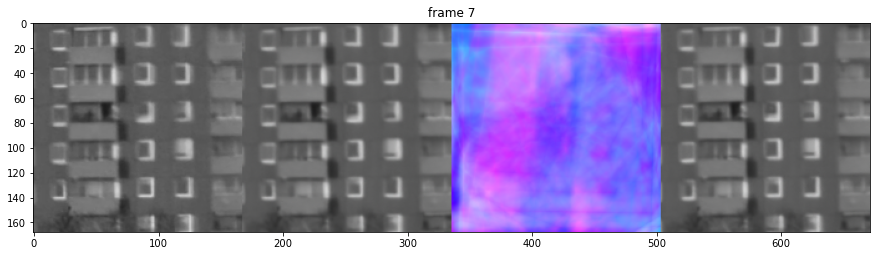

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


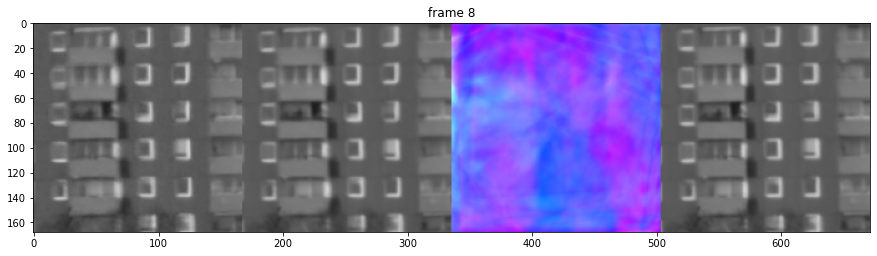

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


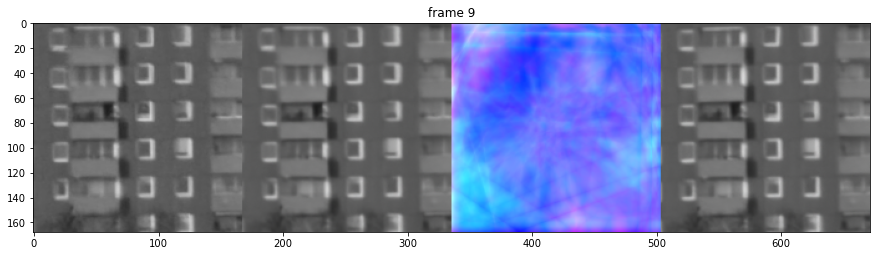

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [17]:
# model_vec = torch.load('{}/{}_vectornet_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
# model_grid = torch.load('{}/{}_gridnet_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size)).type(dtype).cuda()

fresult = '{}/{}/'.format(fresult,batch_size)
if not os.path.exists(fresult):
    os.makedirs(fresult)
    
# -------------------------------SETUP Grid deformer---------------------------------------------------    
refined_xy = []
for b in range(batch_size):
    refined_xy.append(model_vec[b](grid_input_single_gd))
#     refined_xy.append(model_vec[b](xy_grid_var).type(dtype).cuda())
refined_xy = vec_scale*torch.cat(refined_xy)
# -------------------------------------------------------------------------------------------------------
# refined_xy = model_vec(grid_input_gd)
# refined_xy = vec_scale*refined_xy
# -------------------------------------------------------------------------------------------------------

refined_warp = refined_xy - xy_grid_batch_var
refined_uv = torch.cat([(nc - 1.0)*refined_warp[:, 0:1, :, :]/2 , (nr - 1.0)*refined_warp[:, 1:2, :, :]/2], 1)

# refined_uv -= refined_uv.min()
# refined_uv /= refined_uv.max()


generated_turb_imgs = model_grid(GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(refined_xy))

sharp_imgs_predict = model_grid(grid_input)

psnr_arr= compare_psnr(img_gt_np, sharp_imgs_predict[0].detach().cpu().numpy()) 
ssim_arr = ssim(img_gt_np.transpose(1,2,0), sharp_imgs_predict[0].detach().cpu().numpy().transpose(1,2,0),multichannel=True) 

print('PSNR: {}, SSIM: {}'.format(psnr_arr,ssim_arr))
for j in range(batch_size):
#     out_img = generated_turb_imgs[j].detach().cpu().numpy().transpose(1,2,0)
    out_img = generated_turb_imgs[j].detach().cpu().numpy().transpose(1,2,0)
    sharp_img = sharp_imgs_predict[j].detach().cpu().numpy().transpose(1,2,0)
    warp_img= refined_uv[j].detach().cpu().numpy().transpose(1,2,0)
    warp_img -= np.min(warp_img)
    warp_img /= np.max(warp_img)
#         warp_gt = warps_gt_batch_np[i]

    out_target = img_gt_batch_var[j].detach().cpu().numpy().transpose(1,2,0)    
    out_imshow = np.concatenate([out_target,out_img,visualize_rgb_norm(warp_img),sharp_img], axis = 1)
    plt.figure(figsize=(15,5))
    plt.title('frame {}'.format(j))
    plt.imshow(out_imshow)
    plt.show()
    
    imsave('{}/{}_turb_img_gt_{}_FB_{}.png'.format(fresult,pname,j+start_f,FB_img), out_target)
    imsave('{}/{}_turb_img_{}_FB_{}.png'.format(fresult,pname,j+start_f,FB_img), out_img)
    imsave('{}/{}_sharp_img_{}_FB_{}.png'.format(fresult,pname,j+start_f,FB_img), sharp_img) 
    imsave('{}/{}_warp_img_{}_FB_{}.png'.format(fresult,pname,j+start_f,FB_img), visualize_rgb_norm(warp_img))     

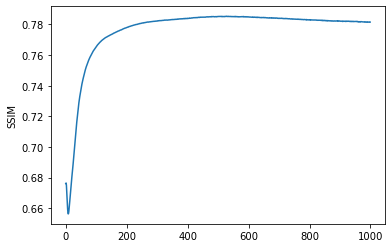

In [18]:
# print(float(loss))
ssim_arr_sharp_np = ssim_arr_sharp.detach().cpu().numpy()
plt.plot(ssim_arr_sharp_np[:])
plt.ylabel('SSIM')
plt.show()

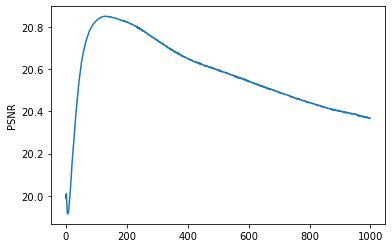

In [19]:
psnr_arr_sharp_np = psnr_arr_sharp.detach().cpu().numpy()
plt.plot(psnr_arr_sharp_np[:])
plt.ylabel('PSNR')
plt.show()

In [20]:
max_index_psnr = np.argmax(psnr_arr_sharp_np)
max_index_ssim = np.argmax(ssim_arr_sharp_np)
print(max(psnr_arr_sharp_np),max(ssim_arr_sharp_np))
print(max_index_psnr,max_index_ssim)

20.849903 0.7853632
132 528
